# Loading Libraries

In [1]:
import os
import time
import yaml
import argparse
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from typing import *
from sklearn.metrics import *
from typing import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score


 # Utility functions

In [2]:
class Data_Proprocesing:
    # This is a class for data preprocessing. It contains some useful functions for data preprocessing.
    def __init__(self) -> None:
        pass
    
    # This function is used to standardize the data.
    def standardize(data:np.ndarray):
        return (data - np.mean(data)) / np.std(data)
    
    # This function is used to one hot encoding the data.
    def one_encoding(X: np.ndarray) -> np.ndarray:
        
        numOfClasses = 10
        
        one_encoding_of_X = []
        
        for each_x in X:
            one_encoding_of_each_x = np.zeros(numOfClasses)
            one_encoding_of_each_x[int(each_x)] = 1
            one_encoding_of_X.append(one_encoding_of_each_x)
                    
        return np.array(one_encoding_of_X)
    
    # This function is used to decode the one hot encoding data.
    def decode_one_encoding(one_encoding: np.ndarray):
        return np.expand_dims(np.argmax(one_encoding, axis=1), axis=1)
        
   # This function is used to shuffle the data into random training set and validation set      
    def shuffle_randomly(X, y):  
        randomize = np.arange(X.shape[0])
        np.random.shuffle(randomize)
        return X[randomize], y[randomize]
    
    # This function is used to compute the accuarcy of the model.
    def accuarcy( y_true: np.ndarray, y_pred:np.ndarray):
        y_pred = np.expand_dims(np.argmax(y_pred, axis=1),axis=1)
        return np.sum(y_true == y_pred) / len(y_true)
    
    # This function is used to compute the confusion matrix of the model.
    def recall_precision_from_confusion_matrix( confusion_matrix: np.ndarray):
        tp = np.diag(confusion_matrix)
        fp = np.sum(confusion_matrix, axis=0) - tp
        fn = np.sum(confusion_matrix, axis=1) - tp
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        return recall, precision


# Components of MLP

In [3]:



class Activation(object):
    """Activation class for the activation function of a neuron"""

    def __tanh(self, x: np.ndarray) -> float:
        return np.tanh(x)

    def __tanh_deriv(self, a: np.ndarray) -> np.ndarray:
        # a = np.tanh(x)
        return 1.0 - a**2

    def __logistic(self, x: np.ndarray) -> float:
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a: np.ndarray) -> float:

        return a * (1 - a)

    def __relu(self, a: np.ndarray) -> np.ndarray:
        return np.maximum(0, a)

    def __relu_deriv(self, a: np.ndarray) -> np.ndarray:
        return np.where(a <= 0, 0, 1)

    def __leakyrelu(self, a: np.ndarray) -> float:
        return np.maximum(self.delta * a, a)

    def __leakyrelu_deriv(self, a: np.ndarray) -> np.ndarray:
        return np.where(a <= 0, self.delta, 1)

    def __softmax(self, a: np.ndarray) -> np.ndarray:
        shift = a - np.max(a, axis=1, keepdims=True)
        return np.exp(shift) / np.sum(np.exp(shift), axis=1, keepdims=True)

    def __softmax_deriv(self, a: np.ndarray) -> np.ndarray:
        a = a.reshape((-1, 1))
        jac = np.diagflat(a) - np.dot(a, a.T)
        return jac

   # Set the activation function of the MLP

    def __init__(self, activation: str = 'tanh', delta: float = 0.01):
        self.indicator = False
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == "leakyrelu":
            self.delta = delta
            self.f = self.__leakyrelu
            self.f_deriv = self.__leakyrelu_deriv
        elif activation == "softmax":

            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv


class HiddenLayer(object):
    """A hidden layer in a multilayer perceptron.
    """

    def __init__(self, n_in: int, n_out: int,
                 activation_last_layer='tanh', activation='tanh', W=None, b=None, output_layer=False, dropout=1.0, weight_decay=None, batch_norm=False):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.mask = None
        self.input = None
        self.activation = Activation(activation).f
        self.dropoutrate = dropout
        self.output_layer = output_layer
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.batch_count = 0

        self.batch_norm = batch_norm
        self.batch_mean = np.zeros((1, n_in))
        self.batch_var = np.zeros((1, n_in))
        self.gamma = np.ones((1, n_in))
        self.beta = np.zeros((1, n_in))
        # activation deriv of last layer
        self.activation_deriv = None
        if activation_last_layer:
            self.activation_deriv = Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization

        if self.activation == 'relu' or self.activation == 'leakyrelu':
            self.W = np.random.uniform(
                low=-np.sqrt(6. / n_in), high=np.sqrt(6. / n_in), size=(n_in, n_out))
        else:
            self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
            )

        # we set the size of bias as the size of output dimension
        self.b = np.zeros((1, n_out),)

        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.v_W = np.zeros_like(self.grad_W)
        self.v_b = np.zeros_like(self.grad_b)

        self.best_WW = None
        self.best_b = None

    def early_stopping_update(self):
        """Update the early stopping counter and check if the training should be stopped.

        Returns
 
        """
        self.best_W = self.W
        self.best_b = self.b

    def forward(self, input: np.ndarray, isTraining: bool = True, dropout_predict=False, early_stopping=False) -> np.ndarray:
        """Feedforward function for the neural network.
    
        Args:
            input (np.ndarray): input to the neural network.
            isTraining (bool): whether or not the network is in training mode.
            dropout_predict (bool): whether or not to use dropout during prediction.
            early_stopping (bool): whether or not to use early stopping.
    
        Returns:
            np.ndarray: output of the neural network.
        """

        # https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwimv42a_tv9AhUsmlYBHSO9BYQQFnoECAwQAQ&url=https%3A%2F%2Fgithub.com%2Frenan-cunha%2FBatchNormalization&usg=AOvVaw28oNAzfY7iGhQg3qVBktzV
        # https://github.com/renan-cunha/BatchNormalization

        if isTraining and not self.output_layer:
            input = self.dropout_forward(input)
        elif self.output_layer:
            self.mask = np.ones(input.shape)

        if self.batch_norm and isTraining is True:
            mean = input.mean(axis=0, keepdims=True)
            var = input.var(axis=0, keepdims=True)
            self.input_normalized = (input - mean) / np.sqrt(var + 1e-18)
            input = self.gamma * self.input_normalized + self.beta

            # we implement the batch normalization in the forward progress with a momentum to keep the mean and var stable, instead of using the numpy arrays to keep all means and var for each iteration during trianing and compute the means for batch mean and standard deviation during inference, we found that this approach is more efficient and speed up the training process significantly.

            self.batch_mean = self.batch_mean * 0.9 + mean * 0.1
            self.batch_var = self.batch_var * 0.9 + var * 0.1
            self.batch_count += 1
        elif self.batch_norm and isTraining is False:
            input = (input - self.batch_mean) / np.sqrt(self.batch_count /
                                                        (self.batch_count - 1) * self.batch_var + 1e-18)
            input = input * self.gamma + self.beta

        scale_factor = 1.0
        if isTraining is False and self.dropoutrate < 1.0:
            scale_factor = self.dropoutrate
        else:
           scale_factor = 1.0

        if isTraining is True and early_stopping:
            lin_output = np.dot(input, self.best_W) + self.best_b
        else:
            lin_output = np.dot(
                input, self.W * scale_factor) + self.b * scale_factor
        self.output = (

            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input = input

        return self.output

    def backward(self, delta: np.ndarray) -> None:
        """
        Backpropagation through this layer
        """

        self.grad_W = np.atleast_2d(self.input).T.dot(
            np.atleast_2d(delta))
        self.grad_b = np.average(delta, axis=0)

        if self.weight_decay is not None:
            self.grad_W += self.weight_decay * self.W

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            delta = self.dropout_backward(delta)

            # retreved from     https://towardsdatascience.com/implementing-batch-normalization-in-python-a044b0369567
            if self.batch_norm:

                self.grad_gamma = np.sum(
                    delta * self.input_normalized, axis=0)
                self.grad_beta = np.sum(delta, axis=0)

        return delta

    def dropout_forward(self, input: np.ndarray) -> np.ndarray:
        """Performs the forward pass of dropout.
        
        Args:
            input: The input data to the layer
        Returns:
            The output of the layer
        """

        self.mask = np.random.binomial(1, self.dropoutrate, size=input.shape)
        # self.mask = np.random.choice([0, 1], size=input.shape, p=[1-self.dropoutrate, self.dropoutrate])
        input = input * self.mask

        #inverted dropout
        # input = input * self.mask/self.dropoutrate
        return input

    def dropout_backward(self, delta: np.ndarray) -> np.ndarray:
        """ Dropout backward pass.
    
        Computes the gradient on the output of a dropout layer.
    
        Args:
            delta: Gradient of loss with respect to the output of the dropout layer.
    
        Returns:
            Gradient of loss with respect to the input of the dropout layer.
        """

        assert self.mask.shape == delta.shape
        return delta * self.mask

    def obtain_mask(self):
        """Obtain a mask for the current image.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        mask : array_like
            The mask for the current image. A mask is a boolean array
            that is the same size as the image, with True values for
            pixels that should be included in the analysis and False
            values for pixels that should be excluded.
        """

        return self.mask


# Optimizers

In [4]:
 

# This is a base class for all optimizers. All optimizers should inherit from this.


class base_optimizer():
    def __init__(self):
        pass

    def reset(self):
        pass

    def init_first_step(self, dw, db):
        pass

    def update_parameter(self, idx, step_count, layer, lr, w, b, dw, db):
        pass


# This is a class for the stochastic gradient descent optimizer. It inherits the base_optimizer class.
# The update_parameter function does a simple weight update using the SGD algorithm.
class sgd(base_optimizer):
    def __init__(self):
        base_optimizer.__init__(self)
        pass

    def update_parameter(self, idx, step_count, layer, lr, w, b, dw, db):
        w -= lr * dw
        b -= lr * db
        return w, b


class sgd_momentum(base_optimizer):
    def __init__(self) -> None:
        base_optimizer.__init__(self)
        pass

    def update_parameter(self, idx, step_count, layer, lr, w, b, dw, db):
        layer.v_W = (0.9 * layer.v_W) + (lr * dw)
        layer.v_b = (0.9 * layer.v_b) + (lr * db)
        w = w - layer.v_W
        b = b - layer.v_b

        return w, b


# This is a class for adam optimizer. It inherits the base_optimizer class.
# The update_parameter function does a simple weight update using the adam algorithm.
class adam(base_optimizer):
    def __init__(self, beta1, beta2):
        base_optimizer.__init__(self)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-16
        self.m_dws = []
        self.v_dws = []
        self.m_dbs = []
        self.v_dbs = []

    def reset(self):
        self.m_dws = []
        self.v_dws = []
        self.m_dbs = []
        self.v_dbs = []

    def init_first_step(self, dw, db):
        self.m_dws.append(np.zeros(dw.shape))
        self.v_dws.append(np.zeros(dw.shape))
        self.m_dbs.append(np.zeros(db.shape))
        self.v_dbs.append(np.zeros(db.shape))

    def update_parameter(self, idx, step_count, layer, lr, w, b, dw, db):

        # beta 1
        self.m_dws[idx] = self.beta1 * self.m_dws[idx] + (1 - self.beta1) * dw
        self.m_dbs[idx] = self.beta1 * self.m_dbs[idx] + (1 - self.beta1) * db

        # beta 2
        self.v_dws[idx] = self.beta2 * \
            self.v_dws[idx] + (1 - self.beta2) * (dw ** 2)
        self.v_dbs[idx] = self.beta2 * \
            self.v_dbs[idx] + (1 - self.beta2) * (db ** 2)

        # correct bias
        m_dw_corrected = self.m_dws[idx] / (1 - self.beta1 ** (step_count))
        m_db_corrected = self.m_dbs[idx] / (1 - self.beta1 ** (step_count))
        v_dw_corrected = self.v_dws[idx] / (1 - self.beta2 ** (step_count))
        v_db_corrected = self.v_dbs[idx] / (1 - self.beta2 ** (step_count))

        # update parameters with adjusted bias and learning rate
        w = w - lr * m_dw_corrected / (np.sqrt(v_dw_corrected) + self.epsilon)
        b = b - lr * m_db_corrected / (np.sqrt(v_db_corrected) + self.epsilon)

        return w, b

# This is a class for RMSprop optimizer. It inherits the base_optimizer class.
# The update_parameter function does a simple weight update using the RMSprop algorithm.


class RMSprop(base_optimizer):
    def __init__(self,  beta2):
        base_optimizer.__init__(self)
        self.beta2 = beta2
        self.epsilon = 1e-16
        self.v_dws = []
        self.v_dbs = []

    def reset(self):
        self.v_dws = []
        self.v_dbs = []

    def init_first_step(self, dw, db):
        self.v_dws.append(np.zeros(dw.shape))
        self.v_dbs.append(np.zeros(db.shape))

    def update_parameter(self, idx, step_count, layer, lr, w, b, dw, db):
        # beta 2
        self.v_dws[idx] = self.beta2 * \
            self.v_dws[idx] + (1 - self.beta2) * (dw ** 2)
        self.v_dbs[idx] = self.beta2 * \
            self.v_dbs[idx] + (1 - self.beta2) * (db ** 2)

        # update parameters with adjusted bias and learning rate
        w = w - lr * dw / (np.sqrt(self.v_dws[idx]) + self.epsilon)
        b = b - lr * db / (np.sqrt(self.v_dbs[idx]) + self.epsilon)

        return w, b


# MLP

In [5]:

class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, X_test: np.ndarray, y_test: np.ndarray, layers: List[int], activation: List[Optional[str]], weight_decay: float = 0.01, loss: str = "MSE", batch_size: int = 1, dropoutRate: float = 0.5, beta: List[float] = [0.9,0.999], batch_norm: bool = False):
         
        # initialize layers
        self.layers: List[HiddenLayer]=[]
        self.params=[]
        self.masks=[]
        self.weight_decay = weight_decay
        self.loss = loss
        self.batch_size = batch_size
        self.X_test = X_test
        self.y_test = y_test
        self.dropoutRate = dropoutRate
        self.activation=activation
        self.step_count = 0
        self.batch_norm = batch_norm
        
        self.beta1 = beta[0]
        self.beta2 = beta[1]
        self.breaking_point = 5
 
        
        
        first_layer = True
        for i in range(len(layers)-1):      
            if i > 0 :
                first_layer = False
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], output_layer = first_layer,dropout=self.dropoutRate, weight_decay=self.weight_decay, batch_norm=self.batch_norm if i != 0 else False))  

 
    def criterion(self, y: np.ndarray, y_hat: np.ndarray, isTraining: bool = True):
        """Compute the loss of the network's prediction with respect to the ground truth.

        Args:
            y (np.ndarray): The ground truth.
            y_hat (np.ndarray): The network's prediction.
            isTraining (bool, optional): Whether the network is in training mode. Defaults to True.

        Returns:
            float: The loss value.
        """
        if self.loss == "MSE":
            return self.criterion_MSE(y,y_hat, isTraining)
        elif self.loss == "CE":
            return self.criterion_CE(y,y_hat, isTraining)
        
        
           
    def criterion_MSE(self, y: np.ndarray, y_hat: np.ndarray, isTraining: bool = True):
        """Computes the Mean Squared Error between the true and predicted values of the data.
    
        Args:
            y: The true values of the data.
            y_hat: The predicted values of the data.
            isTraining: Whether this is being used for training or testing.
    
        Returns:
            The Mean Squared Error between the true and predicted values of the data.
        """

 
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        y = Data_Proprocesing.one_encoding(y)
        
        error = y - y_hat
        loss = error**2
        
        if isTraining is False:
            
            return np.sum(loss)/y.shape[0], None
        
        delta = -error * activation_deriv(y_hat) / y.shape[0]
        return np.sum(loss)/y.shape[0], delta
    
    
    def criterion_CE(self, y:  np.ndarray, y_hat:  np.ndarray, isTraining: bool = True):
        """Computes the cross-entropy loss between the true labels, y, and the predictions, y_hat.
        Args:
            y: The true labels, of shape (batch_size, num_classes).
            y_hat: The model predictions, of shape (batch_size, num_classes).
            isTraining: A boolean indicating whether this is a training step or not. This is used to determine whether to update the running mean and standard deviation.
        Returns:
            The loss, as a scalar.
        """
        
        y = Data_Proprocesing.one_encoding(y)
        # print("y: ",y.shape)
        # print("y_hat", y_hat.shape)
        # print("After scaling loss", loss)
       

        assert y.shape == y_hat.shape

        number_of_sample = y.shape[0]
        loss = - np.nansum(y * np.log(y_hat + 1e-30))
        loss = loss / number_of_sample
        # print("Original loss", loss)
        if isTraining == False:
            return loss, None
        
        # see https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba#:~:text=Putting%20It%20All%20Together
        
        delta = -(y - y_hat) / number_of_sample
        return loss, delta

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self, input:  np.ndarray, isTraining: bool = True, dropout_predict: bool = False, early_stop: bool = False):
        # This is the forward propagation function that is used to predict the output
        # for a given input. It is called when the predict() function is called.
 
        # reset self.masks to empty list            
        for layer in self.layers:
            output=layer.forward(input, isTraining=isTraining, dropout_predict=dropout_predict, early_stopping=early_stop)
            input=output
        return output

    # backward progress  
    def backward(self, delta: np.ndarray):
        # Computes the backward pass of the ReLU activation function
        # delta is the gradient of the loss with respect to the output of the activation function
        # Returns the gradient of the loss with respect to the input of the activation function
 
        for layerIndex in reversed(range(len(self.layers))):
            # print("layer: ", layerIndex)
            delta = self.layers[layerIndex].backward(delta)
                
         

    # update the network weights after backward.
    # make sure you run the backward function before the update function! 
    def optimizer_init(self, method: str) -> None:
        """
        Initialize the optimizer with the given method.
        """
 
        
        if method == "sgd":
            self.opt = sgd()
        elif method == "sgd_momentum":
            self.opt= sgd_momentum()  
        elif method == "adam":
            self.opt= adam(self.beta1, self.beta2)  
        elif method == "rmsprop":
            self.opt = RMSprop(self.beta2)
        
    def update(self,lr: float, step_count: int)->None:         
        if step_count == 1:
            self.opt.reset()
            
        for index, layer in enumerate(self.layers):
            # print("layer: ", index)
            if step_count == 1:
                self.opt.init_first_step(layer.grad_W, layer.grad_b)
                
            layer.W, layer.b = self.opt.update_parameter(
                index, step_count,layer,lr, layer.W, layer.b, layer.grad_W, layer.grad_b)
            
            if layer.batch_norm == True:
                # print("layer.gamma", layer.gamma.shape)
                # print("layer.grad_gamma", layer.grad_gamma.shape)
                layer.gamma -= lr * layer.grad_gamma
                layer.beta -= lr * layer.grad_beta
       

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X:np.ndarray,y:np.ndarray,learning_rate:float=0.1, epochs:int=100, opt: str ='sgd', early_stop: bool = False):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
  
        X=np.array(X)
        y=np.array(y)
        
        print("X shape",X.shape)
        print("y shape",y.shape)
        self.early_stop_mode = early_stop
        
        early_stop_torlerance_runs = 0
        train_loss_per_epochs = []
        val_loss_per_epochs = []
        train_acc_per_epochs = []
        val_acc_per_epochs = []
        train_f1_per_epochs = []
        val_f1_per_epochs = []
        
        best_metric_score = np.inf
        self.optimizer_init(opt)
        num_batches = int(np.ceil(X.shape[0] / self.batch_size))
        
        self.step_count = 1

        for k in range(epochs):
            
            
            index = 0
            current_batch_size = self.batch_size
            X,y = Data_Proprocesing.shuffle_randomly(X,y)


            for batch_indx in tqdm(range(num_batches)):
            
                # forward pass
                y_hat = self.forward(X[index: index + current_batch_size,])
                
                
                # backward pass
                loss, delta = self.criterion(
                    y[index:index + current_batch_size, :], y_hat, isTraining=True)
                
           
                self.backward(delta) 
                
                # update the model parameters
                self.update(learning_rate,step_count=self.step_count)   
                
                
                # correct the batch size if it is the last batch is not full
                index += current_batch_size
                if index + self.batch_size > X.shape[0]:
                    current_batch_size = X.shape[0] - index
                                
                
                
                self.step_count += 1
                
            # keep track of experiment results
            y_train_pred = self.predict(X)
            train_loss, _ = self.criterion(
                y, y_train_pred, isTraining=False)
            train_loss_per_epochs.append(train_loss)
            train_acc_per_epochs.append(accuracy_score(y,  np.expand_dims(np.argmax(y_train_pred, axis=1),axis=1)))
            train_f1_per_epochs.append(f1_score(y,  np.expand_dims(np.argmax(y_train_pred, axis=1),axis=1), average='macro'))
            
            y_test_pred = self.predict(self.X_test)
            val_loss, _ = self.criterion(
                self.y_test, y_test_pred, isTraining=False)
            val_loss_per_epochs.append(val_loss)
            val_acc_per_epochs.append(accuracy_score(
                self.y_test, np.expand_dims(np.argmax(y_test_pred, axis=1), axis=1)))
            val_f1_per_epochs.append(f1_score(self.y_test,  np.expand_dims(np.argmax(y_test_pred, axis=1),axis=1), average='macro')) 
            
            # early stopping implementation
            if self.early_stop_mode:
                if val_loss < best_metric_score:
                    best_metric_score = val_loss
                    early_stop_torlerance_runs = 0
                    self.early_stop_save()
                    print(".....saving model!")
                    
                else:
                    early_stop_torlerance_runs += 1
                    
                print('val_loss: ', val_loss)
                print('best_val_loss: ', best_metric_score)
                print('early_stop_torlerance_runs: ', early_stop_torlerance_runs)
                
                if early_stop_torlerance_runs >= self.breaking_point:
                    break
                   
        
            print(
                f'Epoch: {k:3} | ' f'itrs: {self.step_count:5} |'
                f' train_loss_per_epochs : {train_loss_per_epochs[-1]:.4f} | '
                f' train_acc_per_epochs : {train_acc_per_epochs[-1]:.4f} | '
                f'val_loss_per_epochs : {val_loss_per_epochs[-1]:.4f} |'
                f' val_acc_per_epochs : {val_acc_per_epochs[-1]:.4f} |'
                f' train_f1_per_epochs : {train_f1_per_epochs[-1]:.4f} |'
                f' val_f1_per_epochs : {val_f1_per_epochs[-1]:.4f} |'
            )

        statistic = dict()
        statistic['train_loss_per_epochs'] = train_loss_per_epochs
        statistic['val_loss_per_epochs'] = val_loss_per_epochs
        statistic['train_acc_per_epochs'] = train_acc_per_epochs
        statistic['val_acc_per_epochs'] = val_acc_per_epochs  
        statistic['train_f1_per_epochs'] = train_f1_per_epochs
        statistic['val_f1_per_epochs'] = val_f1_per_epochs

        
        return  statistic

    
    def early_stop_save(self):
        """Save the model if the validation loss has decreased"""

        for layerIndex in reversed(range(len(self.layers))):
            self.layers[layerIndex].early_stopping_update()
       
       
    def predict_early_stop(self, x: np.ndarray):
        """
        Predicts the output of the model given a set of input data points.
        If the model has not implemented early stopping in a fit method, this function will raise an
        exception.
        
        :param x: the input data points
        :return: the output of the model
        """
    
        assert self.early_stop_mode == True, "early_stop_mode is not activated"
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:], isTraining=False, early_stop=True))
        return np.array(output).squeeze(axis=1) 
        
            
    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Given a set of input features, predicts the output values for each
        input feature. This function is called in the predict function in
        the Model class.
        """ 
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:], isTraining=False))
    
        return np.array(output).squeeze(axis=1) 


# Training and Predictions

os.path.join(file_location, "train_data.npy"):  d:\coding_files\DL_assign1\raw_data\train_data.npy
-----------------------------------
============= Model Starts Building =============
X shape (10000, 128)
y shape (10000, 1)


100%|██████████| 20/20 [00:00<00:00, 67.73it/s]


Epoch:   0 | itrs:    21 | train_loss_per_epochs : 2.0968 |  train_acc_per_epochs : 0.2452 | val_loss_per_epochs : 2.1112 | val_acc_per_epochs : 0.2476 | train_f1_per_epochs : 0.2254 | val_f1_per_epochs : 0.2289 |


100%|██████████| 20/20 [00:00<00:00, 92.70it/s]


Epoch:   1 | itrs:    41 | train_loss_per_epochs : 1.9507 |  train_acc_per_epochs : 0.3152 | val_loss_per_epochs : 1.9730 | val_acc_per_epochs : 0.3066 | train_f1_per_epochs : 0.3061 | val_f1_per_epochs : 0.2976 |


100%|██████████| 20/20 [00:00<00:00, 105.70it/s]


Epoch:   2 | itrs:    61 | train_loss_per_epochs : 1.8496 |  train_acc_per_epochs : 0.3557 | val_loss_per_epochs : 1.8871 | val_acc_per_epochs : 0.3427 | train_f1_per_epochs : 0.3504 | val_f1_per_epochs : 0.3374 |


100%|██████████| 20/20 [00:00<00:00, 100.42it/s]


Epoch:   3 | itrs:    81 | train_loss_per_epochs : 1.7708 |  train_acc_per_epochs : 0.3808 | val_loss_per_epochs : 1.8248 | val_acc_per_epochs : 0.3562 | train_f1_per_epochs : 0.3755 | val_f1_per_epochs : 0.3506 |


100%|██████████| 20/20 [00:00<00:00, 93.72it/s]


Epoch:   4 | itrs:   101 | train_loss_per_epochs : 1.7081 |  train_acc_per_epochs : 0.4068 | val_loss_per_epochs : 1.7782 | val_acc_per_epochs : 0.3761 | train_f1_per_epochs : 0.4040 | val_f1_per_epochs : 0.3733 |
============= Model Build Done =============
Time taken to build model: 11.7024 seconds with 5 Epochs of training.
============= Results plotting =============
Final_evaluate_val_acc:  0.3761
============= Results plotting finished =============


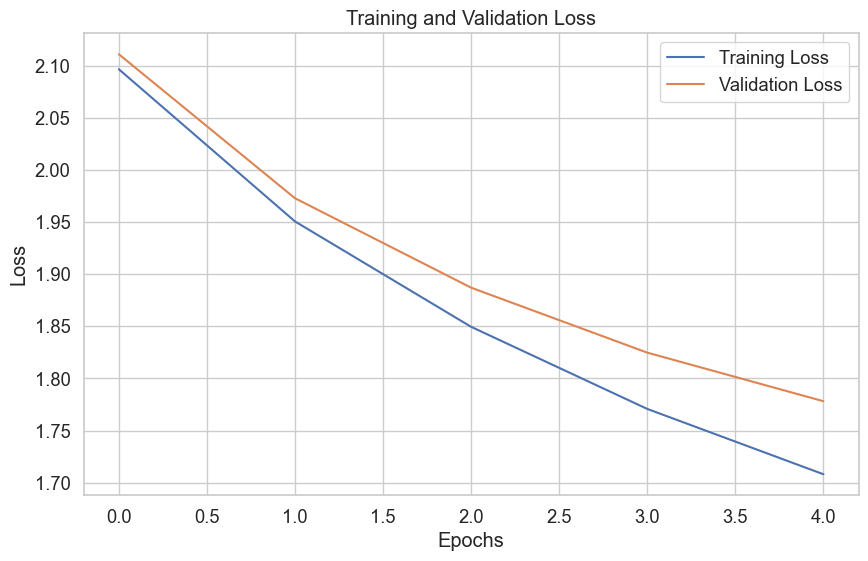

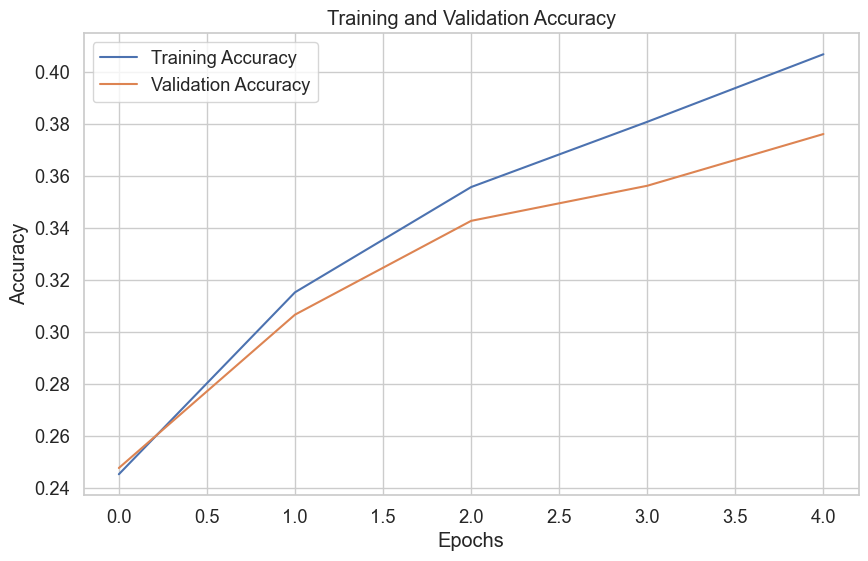

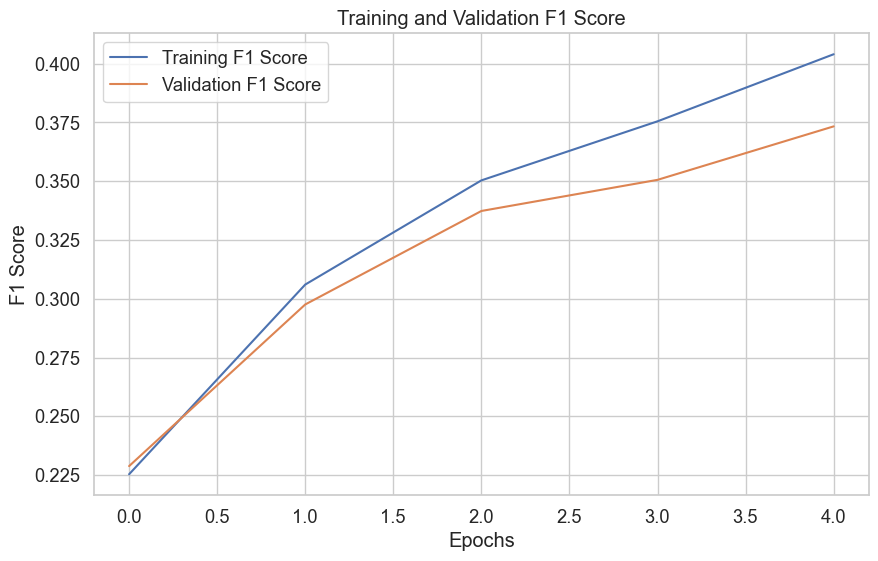

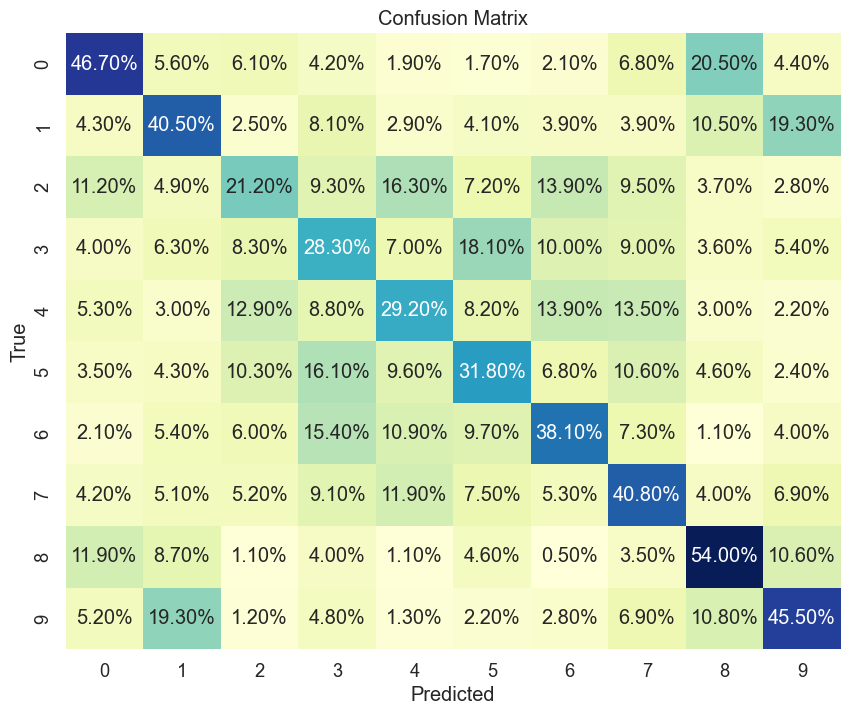

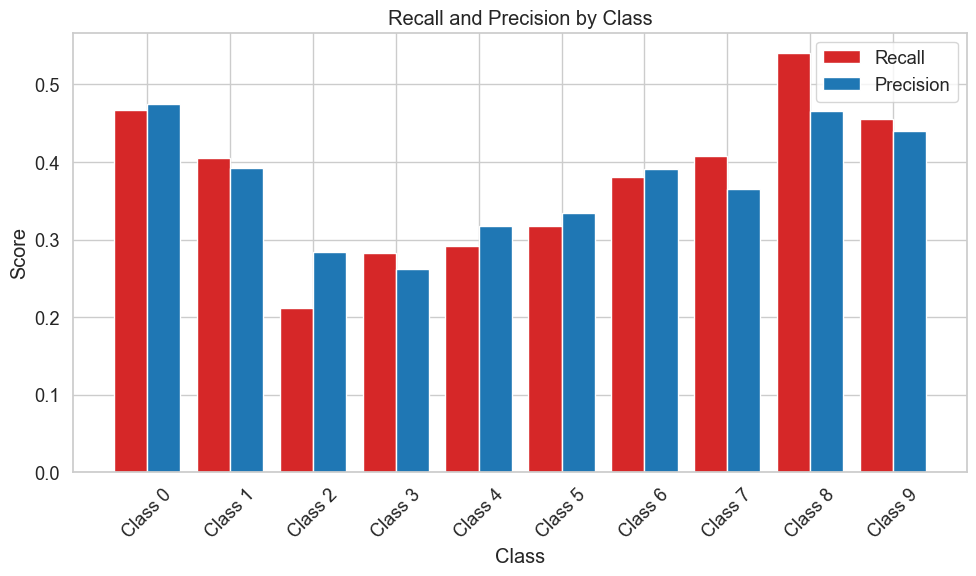

In [8]:
debug = False

#----------------------------------------------------------------------------------
#Set default hyperparameters
# specify the number of layers and neurons in each layer
layer_neurons = [128, 150, 100, 10]
# optins: None, linear,leakyrelu,relu,softmax,logistic
activation_funcs = ['None', 'relu', 'relu', 'softmax']
learning_rate = 0.0005  # learning rate for the optimizer
epochs = 5  # number of training epochs
dropout_prob = 1  # dropout probability that perserve the neuron
# dropout probability must be between 0 and 1
assert 0 <= dropout_prob <= 1
batch_size = 512  # if batch_size is None, then no batch is used
weight_decay = 0  # if weight_decay is None, then no weight decay is applied
beta = [0.9, 0.999]  # beta values for the adam optimizer
size = 10000  # Size of training dataset, 50000 is the full dataset
batch_norm = False  # True or False for batch normalization
loss = 'CE'  # 'CE' or 'MSE'
optimizer = 'adam'  # 'sgd' or 'adam', 'sgd_momentum' 'rmsprop'
save_path = '.\\jupyter_results\\debug\\'  # path to save the results
file_location = "d:\\coding_files\\DL_assign1\\raw_data"  # path to the raw data
early_stopping = False  # True or False for early stopping
# This means that the default batch normalization is not used, there is a argument being passed to this batch_norm
if isinstance(batch_norm, str):
    if batch_norm == "False":
        batch_norm = False
    else:
        batch_norm = True

# ----------------------------------------------------------------------------------
# Load datasets
print('os.path.join(file_location, "train_data.npy"): ', os.path.join(file_location, "train_data.npy"))
X_train = np.load(os.path.join(file_location, "train_data.npy"))

y_train = np.load(os.path.join(file_location, "train_label.npy"))
X_test = np.load(os.path.join(file_location, "test_data.npy"))
y_test = np.load(os.path.join(file_location, "test_label.npy"))
if debug:
    print('X_train: ', X_train.shape)
    print('y_train: ', y_train.shape)
    print('X_test: ', X_test.shape)
    print('y_test: ', y_test.shape)
    print(y_train[:10, :])

# ----------------------------------------------------------------------------------
# Preprocess data
X_train = Data_Proprocesing.standardize(X_train)
X_test = Data_Proprocesing.standardize(X_test)

if debug:
    print("--"*30)
    print(y_train[:10, :])
    print(Data_Proprocesing.decode_one_encoding(y_train[:10]))
    X_shuffle, y_shuffle = Data_Proprocesing.shuffle_randomly(
        X_train[:10, :], y_train[:10, :])
    print(y_shuffle)
    print(Data_Proprocesing.decode_one_encoding(y_shuffle))
    print("--"*30)

# ----------------------------------------------------------------------------------
# Create the directory to save the results
if not os.path.exists(save_path):
    os.makedirs(save_path)
    

# Save the dictionary to a yaml file
for index, each in enumerate(activation_funcs):
    if each == "None":
        activation_funcs[index] = None

print("-----------------------------------")
# ----------------------------------------------------------------------------------
# Instantiate the multi-layer neural network
assert len(layer_neurons) == len(activation_funcs)
nn = MLP(X_test, y_test,
         layers=layer_neurons, activation=activation_funcs,

         dropoutRate=dropout_prob, weight_decay=weight_decay,
         loss=loss, batch_size=batch_size, beta=beta,
         batch_norm=batch_norm)

# Perform fitting using the training dataset
t0 = time.time()
print(f"============= Model Starts Building =============")
trial1_logger = nn.fit(X_train[:size], y_train[:size],
                       learning_rate=learning_rate, epochs=epochs,
                       opt=optimizer, early_stop=early_stopping)

t1 = time.time()  # end time
print(f"============= Model Build Done =============")
print(
    f"Time taken to build model: {round(t1 - t0, 4)} seconds with {epochs} Epochs of training.")


# ----------------------------------------------------------------------------------
# Plot the results
print(f"============= Results plotting =============")
# save a csv file
df_stats = pd.DataFrame.from_dict(trial1_logger)
# Save the DataFrame as a CSV file using save_path location
df_stats.to_csv(save_path + 'stats.csv', index=False)


sns.set(style='whitegrid', font_scale=1.2)  # set the style of the plots

#  plot training and validation loss
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=trial1_logger['train_loss_per_epochs'], label='Training Loss')
sns.lineplot(
    data=trial1_logger['val_loss_per_epochs'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(os.path.join(save_path, 'loss.png'), dpi=300)

#  plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=trial1_logger['train_acc_per_epochs'], label='Training Accuracy')
sns.lineplot(
    data=trial1_logger['val_acc_per_epochs'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig(os.path.join(save_path, 'accuracy.png'), dpi=300)

#   plot training and validation F1 score
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=trial1_logger['train_f1_per_epochs'], label='Training F1 Score')
sns.lineplot(data=trial1_logger['val_f1_per_epochs'],
             label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.savefig(os.path.join(save_path, 'f1_score.png'), dpi=300)


# heatmap of confusion matrixss
if early_stopping:
    y_pred = nn.predict_early_stop(X_test)
else:
    y_pred = nn.predict(X_test)
y_pred_decoded = Data_Proprocesing.decode_one_encoding(y_pred)

cm = confusion_matrix(y_test, y_pred_decoded)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
val_acc = accuracy_score(y_test,  np.expand_dims(
    np.argmax(y_pred, axis=1), axis=1))
print('Final_evaluate_val_acc: ', val_acc)
recall, precision = Data_Proprocesing.recall_precision_from_confusion_matrix(
    cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, cmap='YlGnBu', fmt='.2%', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(save_path, 'confusion_matrix.png'), dpi=300)


# Compute recall and precision for each class
class_labels = [f'Class {i}' for i in range(cm.shape[0])]

# Define color map for recall and precision
colors = ['tab:red', 'tab:blue']

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot recall and precision as comparative bar chart
bar_width = 0.4
x_pos = np.arange(len(class_labels))
ax.bar(x_pos - bar_width/2, recall, width=bar_width,
       color=colors[0], label='Recall')
ax.bar(x_pos + bar_width/2, precision, width=bar_width,
       color=colors[1], label='Precision')

# Set axis labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels(class_labels, rotation=45)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Recall and Precision by Class')

# Add legend
ax.legend()

# Adjust layout and save figure
fig.tight_layout()
plt.savefig(os.path.join(save_path, 'recall_precision.png'), dpi=300)
print(f"============= Results plotting finished =============")
